# Generisanje umetničkih dela pomoću neuronskog prenosa stila

Neuronski transfer stila je spajanje slike sadržaja (content C) sa slikom stila (style S) da bi nastala generisana slika (generated G). Korišćena je već trenirana VGG-16 mreža.

In [93]:
# Učitavanje biblioteka
import numpy as np
from PIL import Image
import requests
from io import BytesIO

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from scipy.optimize import fmin_l_bfgs_b

In [94]:
# Putanje gde se čuvaju slike
input_image_path = "images/input.png"
style_image_path = "images/style.png"
output_image_path = "output/output11.png"
combined_image_path = "output/combined11.png"

# Putanje sa kojih se čitaju slike
input_img = "images/cat.jpg"
style_img = "images/psy.jpg"


In [96]:
# Hiperparametri
ITERATIONS = 15
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.015
STYLE_WEIGHT = 4.65
TOTAL_VARIATION_WEIGHT = 0.994
TOTAL_VARIATION_LOSS_FACTOR = 1.5

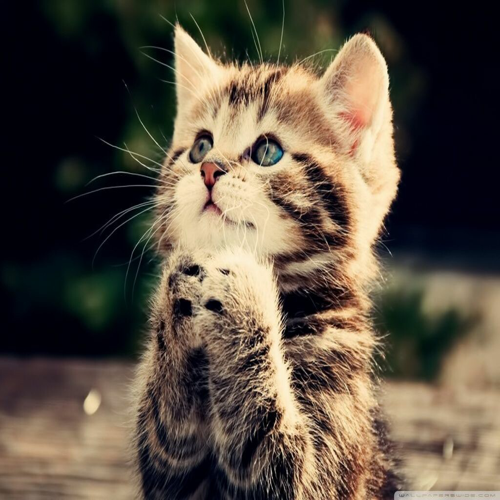

In [97]:
# Prikaz ulazne slike

input_image = Image.open(input_img)
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image.save(input_image_path)
input_image

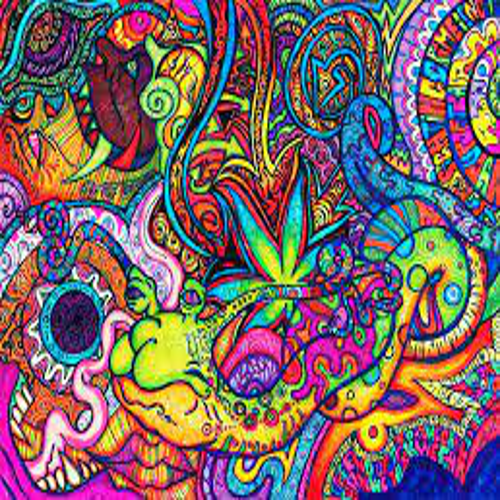

In [98]:
# Prikaz stilske slike

style_image = Image.open(style_img)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
style_image

In [99]:
# Normalizacija i prebacivanje sa RGB na BGR

input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)
input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]


In [100]:
# Model

input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)

**Content loss** funkcija služi za izračunavanje rastojanja između ulazne i izlazne slike, težimo očuvanju sadržaja.

In [101]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layers = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = "block2_conv2"
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

print(layer_features[0,])

loss = backend.variable(0.)
print(loss)
loss = loss + CONTENT_WEIGHT * content_loss(content_image_features, combination_features)

Tensor("strided_slice_255:0", shape=(250, 250, 128), dtype=float32)
<tf.Variable 'Variable_26:0' shape=() dtype=float32>


In [102]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

**Compute style loss** funkcija služi za izračunavanje rastojanje između stila i izlazne slike, težimo da primenimo novi stil.

In [103]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss

print(layer_features[1,])
print(layer_features[2,])

Tensor("strided_slice_276:0", shape=(31, 31, 512), dtype=float32)
Tensor("strided_slice_277:0", shape=(31, 31, 512), dtype=float32)


**Total variation loss** funkcija služi za regularizaciju, smanjenje šuma na izlazu. 

In [104]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)
print(loss)

Tensor("add_82:0", shape=(), dtype=float32)


In [105]:
outputs = [loss]
outputs = outputs + tf.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

Iteracija 1 završena sa gubicima: 255333498880
Iteracija 2 završena sa gubicima: 179195297792
Iteracija 3 završena sa gubicima: 161519239168
Iteracija 4 završena sa gubicima: 153036177408
Iteracija 5 završena sa gubicima: 147925172224
Iteracija 6 završena sa gubicima: 144139288576
Iteracija 7 završena sa gubicima: 141761380352
Iteracija 8 završena sa gubicima: 139930025984
Iteracija 9 završena sa gubicima: 138165698560
Iteracija 10 završena sa gubicima: 136979218432
Iteracija 11 završena sa gubicima: 136182775808
Iteracija 12 završena sa gubicima: 135511998464
Iteracija 13 završena sa gubicima: 134922911744
Iteracija 14 završena sa gubicima: 134501138432
Iteracija 15 završena sa gubicima: 134055108608


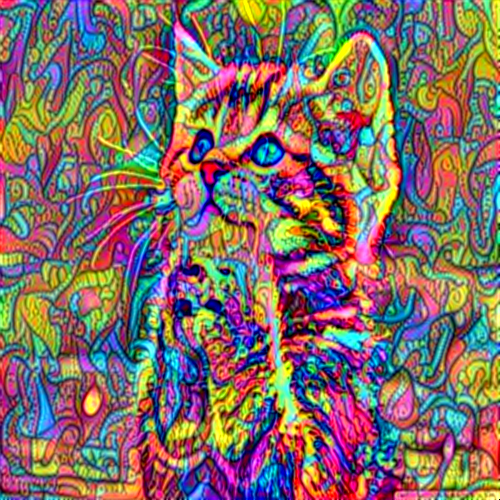

In [106]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteracija %d završena sa gubicima: %d" % (i+1, loss))
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image

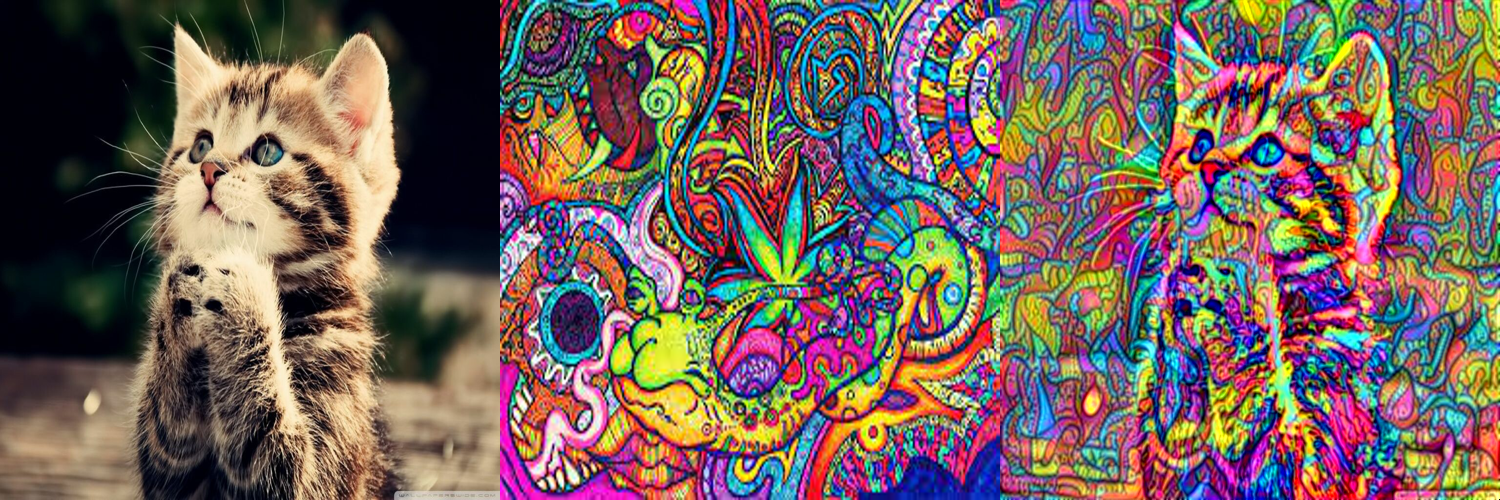

In [107]:
# Prikaz kombinovanih rezultata

combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [input_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined

![Output2](output/combined2.png)  
![Output3](output/combined3.png)  
![Output4](output/combined4.png)  
![Output5](output/combined5.png)  
![Output6](output/combined6.png)  
![Output7](output/combined7.png)  
![Output8](output/combined8.png)  
![Output9](output/combined9.png)  
![Output10](output/combined10.png)  
![Output11](output/combined11.png)  
